In [1]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.8 MB/s eta 0:00:00


In [2]:
!pip install stable_baselines3 gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 18.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2398998 sha256=959307cfc226c6163272eb02fed9697ca18371b77f2a39c0b4fe2bf92d57ea95
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [3]:
import os, platform, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="This system does not have CUDA")
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")

import numpy as np
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.atari_wrappers import WarpFrame  # 84x84 grayscale
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import (
    VecFrameStack, VecTransposeImage, VecNormalize, VecVideoRecorder
)
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.torch_layers import NatureCNN
from importlib.metadata import version

print(f"Python: {platform.python_version()}")
print(f"Torch:  {version('torch')} | CUDA avail: {torch.cuda.is_available()} | torch.cuda: {torch.version.cuda}")
print(f"Gymnasium: {version('gymnasium')}")
print(f"SB3: {version('stable_baselines3')}")
print(f"Numpy: {version('numpy')}  Matplotlib: {version('matplotlib')}")


Python: 3.12.12
Torch:  2.9.0+cu126 | CUDA avail: True | torch.cuda: 12.6
Gymnasium: 1.2.2
SB3: 2.7.0
Numpy: 2.0.2  Matplotlib: 3.10.0


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# --------------------
# Config (faster run)
# --------------------
ENV_ID = "CarRacing-v3"
LOG_DIR = f"./logs/{ENV_ID}"
VIDEO_DIR = "./videos"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(VIDEO_DIR, exist_ok=True)

TOTAL_STEPS = 500_000       # ↓ from 1M
EVAL_FREQ = 20_000          # evaluate a bit less often
EVAL_EPISODES = 5           # fewer episodes during training to save time
FINAL_EVAL_EPISODES = 20    # do a fuller eval at the end for your report
SEED = 42

USE_GRAY = True
WRAPPER_CLASS = WarpFrame if USE_GRAY else None

def make_training_env(seed=SEED):
    env = make_vec_env(ENV_ID, n_envs=1, seed=seed, wrapper_class=WRAPPER_CLASS)
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)
    # Reward normalization helps SAC stability on pixels
    env = VecNormalize(env, norm_obs=False, norm_reward=True, clip_reward=10.0)
    return env

def make_eval_env(seed=SEED+1):
    env = make_vec_env(ENV_ID, n_envs=1, seed=seed, wrapper_class=WRAPPER_CLASS)
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)
    env = VecNormalize(env, norm_obs=False, norm_reward=True, clip_reward=10.0, training=False)
    return env

train_env = make_training_env(SEED)
eval_env = make_eval_env(SEED + 1)

policy_kwargs = dict(
    features_extractor_class=NatureCNN,
    features_extractor_kwargs=dict(features_dim=512),  # stronger CNN head
    net_arch=[256, 256],
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=LOG_DIR,
    log_path=LOG_DIR,
    eval_freq=EVAL_FREQ,
    n_eval_episodes=EVAL_EPISODES,
    deterministic=True,
    render=False,
)


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [5]:
# --------------------
# SAC hyperparams (slightly lighter/faster)
# --------------------
model = SAC(
    "CnnPolicy",
    train_env,
    learning_rate=1e-4,
    buffer_size=500_000,        # ↓ from 1,000,000 to reduce RAM/time
    batch_size=256,
    learning_starts=5_000,      # ↓ warmup so learning begins earlier
    gamma=0.99,
    tau=0.005,
    ent_coef="auto",
    target_entropy="auto",
    train_freq=(1, "step"),
    gradient_steps=1,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log=LOG_DIR,
    seed=SEED,
)

Using cuda device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
# --------------------
# Train
# --------------------
model.learn(total_timesteps=TOTAL_STEPS, callback=eval_callback, progress_bar=True)

# Save final model and normalization stats
final_model_path = os.path.join(LOG_DIR, "sac_car_racing_final_500k")
model.save(final_model_path)
train_env.save(os.path.join(LOG_DIR, "vecnormalize.pkl"))



Logging to ./logs/CarRacing-v3/SAC_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -31.6    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 94       |
|    time_elapsed    | 42       |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -35      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 38       |
|    time_elapsed    | 206      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -23.3    |
|    critic_loss     | 0.0994   |
|    ent_coef        | 0.741    |
|    ent_coef_loss   | -1.51    |
|    learning_rate   | 0.0001   |
|    n_updates       | 2999     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=20000, episode_reward=-18.57 +/- 16.33

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -18.6    |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -48      |
|    critic_loss     | 0.0523   |
|    ent_coef        | 0.223    |
|    ent_coef_loss   | -7.57    |
|    learning_rate   | 0.0001   |
|    n_updates       | 14999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -32.9    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 23       |
|    time_elapsed    | 867      |
|    total_timesteps | 20000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -32.5    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 22       |
|    time_elapsed    | 1070     |
|    total_timesteps | 24000    |
| train/             |          |
|    actor_loss      | -45.5    |
|    critic_loss     | 0.0299   |
|    ent_coef        | 0.15     |
|    ent_coef_loss   | -9.62    |
|    learning_rate   | 0.0001   |
|    n_updates       | 18999    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=40000, episode_reward=-30.38 +/- 5.07

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -30.4    |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -26.8    |
|    critic_loss     | 0.0473   |
|    ent_coef        | 0.0302   |
|    ent_coef_loss   | -17.7    |
|    learning_rate   | 0.0001   |
|    n_updates       | 34999    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -32.7    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 20       |
|    time_elapsed    | 1938     |
|    total_timesteps | 40000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -32.7    |
| time/              |          |
|    episodes 

Eval num_timesteps=60000, episode_reward=-23.61 +/- 14.95

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -23.6    |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -9.97    |
|    critic_loss     | 0.0286   |
|    ent_coef        | 0.00409  |
|    ent_coef_loss   | -27.7    |
|    learning_rate   | 0.0001   |
|    n_updates       | 54999    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -32      |
| time/              |          |
|    episodes        | 60       |
|    fps             | 19       |
|    time_elapsed    | 3012     |
|    total_timesteps | 60000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -31.6    |
| time/              |          |
|    episodes 

Eval num_timesteps=80000, episode_reward=-79.25 +/- 0.77

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -79.3    |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -3.54    |
|    critic_loss     | 0.0215   |
|    ent_coef        | 0.000899 |
|    ent_coef_loss   | -1.23    |
|    learning_rate   | 0.0001   |
|    n_updates       | 74999    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -38.6    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 19       |
|    time_elapsed    | 4088     |
|    total_timesteps | 80000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -40.5    |
| time/              |          |
|    episodes 

Eval num_timesteps=100000, episode_reward=-78.17 +/- 3.04

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -78.2    |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -1.01    |
|    critic_loss     | 0.0106   |
|    ent_coef        | 0.000154 |
|    ent_coef_loss   | 4.87     |
|    learning_rate   | 0.0001   |
|    n_updates       | 94999    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 997      |
|    ep_rew_mean     | -42.9    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 19       |
|    time_elapsed    | 5358     |
|    total_timesteps | 103713   |
| train/             |          |
|    actor_loss      | -0.848   |
|    critic_loss     | 0.00764  |
|    ent_coef        | 0.000205 |
|    ent_coef_loss   | 10.5     |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=120000, episode_reward=524.31 +/- 302.41

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 524      |
| time/              |          |
|    total_timesteps | 120000   |
| train/             |          |
|    actor_loss      | -0.885   |
|    critic_loss     | 0.00501  |
|    ent_coef        | 0.000836 |
|    ent_coef_loss   | 2.47     |
|    learning_rate   | 0.0001   |
|    n_updates       | 114999   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 995      |
|    ep_rew_mean     | 18.4     |
| time/              |          |
|    episodes        | 124      |
|    fps             | 19       |
|    time_elapsed    | 6436     |
|    total_timesteps | 123460   |
| train/             |          |
|    actor_loss      | -0.997   |
|    critic_loss     | 0.00685  |
|    ent_coef        | 0.00103  |
|    ent_coef_loss   | -3.11    |
|    learning_rate   | 0.0001   |
|    n_updates       | 118459   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 995      |
|    ep_rew_mean     | 39.5     |
| time/              |          |
|    episodes        | 128      |
|    fps             | 19       |
|    time_elapsed    | 6641     |
|    total_timesteps | 127460   |
| train/             |          |
|    actor_loss      | -1.06    |
|    critic_loss     | 0.00446  |
|    ent_coef 

Eval num_timesteps=140000, episode_reward=723.94 +/- 143.86

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 724      |
| time/              |          |
|    total_timesteps | 140000   |
| train/             |          |
|    actor_loss      | -1.38    |
|    critic_loss     | 0.00522  |
|    ent_coef        | 0.00105  |
|    ent_coef_loss   | -0.594   |
|    learning_rate   | 0.0001   |
|    n_updates       | 134999   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 991      |
|    ep_rew_mean     | 133      |
| time/              |          |
|    episodes        | 144      |
|    fps             | 19       |
|    time_elapsed    | 7511     |
|    total_timesteps | 143135   |
| train/             |          |
|    actor_loss      | -1.36    |
|    critic_loss     | 0.00461  |
|    ent_coef        | 0.00118  |
|    ent_coef_loss   | 4.96     |
|    learning_rate   | 0.0001   |
|    n_updates       | 138134   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 991      |
|    ep_rew_mean     | 157      |
| time/              |          |
|    episodes        | 148      |
|    fps             | 19       |
|    time_elapsed    | 7715     |
|    total_timesteps | 147135   |
| train/             |          |
|    actor_loss      | -1.39    |
|    critic_loss     | 0.00464  |
|    ent_coef 

Eval num_timesteps=160000, episode_reward=296.36 +/- 331.31

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 296      |
| time/              |          |
|    total_timesteps | 160000   |
| train/             |          |
|    actor_loss      | -1.66    |
|    critic_loss     | 0.00581  |
|    ent_coef        | 0.00139  |
|    ent_coef_loss   | -1.45    |
|    learning_rate   | 0.0001   |
|    n_updates       | 154999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 991      |
|    ep_rew_mean     | 170      |
| time/              |          |
|    episodes        | 164      |
|    fps             | 18       |
|    time_elapsed    | 8586     |
|    total_timesteps | 163135   |
| train/             |          |
|    actor_loss      | -1.71    |
|    critic_loss     | 0.00602  |
|    ent_coef        | 0.00137  |
|    ent_coef_loss   | -0.711   |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=180000, episode_reward=-85.45 +/- 6.25

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -85.5    |
| time/              |          |
|    total_timesteps | 180000   |
| train/             |          |
|    actor_loss      | -1.57    |
|    critic_loss     | 0.00359  |
|    ent_coef        | 0.000938 |
|    ent_coef_loss   | 2.82     |
|    learning_rate   | 0.0001   |
|    n_updates       | 174999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 991      |
|    ep_rew_mean     | 190      |
| time/              |          |
|    episodes        | 184      |
|    fps             | 18       |
|    time_elapsed    | 9661     |
|    total_timesteps | 183135   |
| train/             |          |
|    actor_loss      | -1.44    |
|    critic_loss     | 0.00354  |
|    ent_coef        | 0.00103  |
|    ent_coef_loss   | -1.88    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=200000, episode_reward=-11.20 +/- 151.92

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -11.2    |
| time/              |          |
|    total_timesteps | 200000   |
| train/             |          |
|    actor_loss      | -1.52    |
|    critic_loss     | 0.00888  |
|    ent_coef        | 0.000974 |
|    ent_coef_loss   | 2.47     |
|    learning_rate   | 0.0001   |
|    n_updates       | 194999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 994      |
|    ep_rew_mean     | 292      |
| time/              |          |
|    episodes        | 204      |
|    fps             | 18       |
|    time_elapsed    | 10745    |
|    total_timesteps | 203135   |
| train/             |          |
|    actor_loss      | -1.62    |
|    critic_loss     | 0.00438  |
|    ent_coef        | 0.000963 |
|    ent_coef_loss   | -1.91    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=220000, episode_reward=-88.99 +/- 2.04

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -89      |
| time/              |          |
|    total_timesteps | 220000   |
| train/             |          |
|    actor_loss      | -2.02    |
|    critic_loss     | 0.0111   |
|    ent_coef        | 0.00127  |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 0.0001   |
|    n_updates       | 214999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 997      |
|    ep_rew_mean     | 233      |
| time/              |          |
|    episodes        | 224      |
|    fps             | 18       |
|    time_elapsed    | 11822    |
|    total_timesteps | 223135   |
| train/             |          |
|    actor_loss      | -2.23    |
|    critic_loss     | 0.0242   |
|    ent_coef        | 0.00117  |
|    ent_coef_loss   | 0.81     |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=240000, episode_reward=-77.94 +/- 17.44

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -77.9    |
| time/              |          |
|    total_timesteps | 240000   |
| train/             |          |
|    actor_loss      | -2.2     |
|    critic_loss     | 0.033    |
|    ent_coef        | 0.00139  |
|    ent_coef_loss   | -0.617   |
|    learning_rate   | 0.0001   |
|    n_updates       | 234999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 111      |
| time/              |          |
|    episodes        | 244      |
|    fps             | 18       |
|    time_elapsed    | 12895    |
|    total_timesteps | 243135   |
| train/             |          |
|    actor_loss      | -2.94    |
|    critic_loss     | 0.0379   |
|    ent_coef        | 0.00145  |
|    ent_coef_loss   | 0.616    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=260000, episode_reward=-53.58 +/- 2.52

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -53.6    |
| time/              |          |
|    total_timesteps | 260000   |
| train/             |          |
|    actor_loss      | -4.2     |
|    critic_loss     | 0.493    |
|    ent_coef        | 0.00302  |
|    ent_coef_loss   | 1.16     |
|    learning_rate   | 0.0001   |
|    n_updates       | 254999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 66.9     |
| time/              |          |
|    episodes        | 264      |
|    fps             | 18       |
|    time_elapsed    | 13973    |
|    total_timesteps | 263135   |
| train/             |          |
|    actor_loss      | -4.05    |
|    critic_loss     | 0.0581   |
|    ent_coef        | 0.00348  |
|    ent_coef_loss   | 0.947    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=280000, episode_reward=-60.06 +/- 10.65

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -60.1    |
| time/              |          |
|    total_timesteps | 280000   |
| train/             |          |
|    actor_loss      | -5.43    |
|    critic_loss     | 0.63     |
|    ent_coef        | 0.00303  |
|    ent_coef_loss   | -0.336   |
|    learning_rate   | 0.0001   |
|    n_updates       | 274999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 48       |
| time/              |          |
|    episodes        | 284      |
|    fps             | 18       |
|    time_elapsed    | 15051    |
|    total_timesteps | 283135   |
| train/             |          |
|    actor_loss      | -4.95    |
|    critic_loss     | 0.15     |
|    ent_coef        | 0.00321  |
|    ent_coef_loss   | -0.114   |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=300000, episode_reward=-73.17 +/- 11.71

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -73.2    |
| time/              |          |
|    total_timesteps | 300000   |
| train/             |          |
|    actor_loss      | -5.34    |
|    critic_loss     | 0.34     |
|    ent_coef        | 0.00378  |
|    ent_coef_loss   | -0.41    |
|    learning_rate   | 0.0001   |
|    n_updates       | 294999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -57.9    |
| time/              |          |
|    episodes        | 304      |
|    fps             | 18       |
|    time_elapsed    | 16131    |
|    total_timesteps | 303135   |
| train/             |          |
|    actor_loss      | -6.56    |
|    critic_loss     | 0.23     |
|    ent_coef        | 0.00387  |
|    ent_coef_loss   | 1.09     |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=320000, episode_reward=-48.35 +/- 28.16

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -48.4    |
| time/              |          |
|    total_timesteps | 320000   |
| train/             |          |
|    actor_loss      | -6.83    |
|    critic_loss     | 0.406    |
|    ent_coef        | 0.00615  |
|    ent_coef_loss   | -0.399   |
|    learning_rate   | 0.0001   |
|    n_updates       | 314999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -64.8    |
| time/              |          |
|    episodes        | 324      |
|    fps             | 18       |
|    time_elapsed    | 17211    |
|    total_timesteps | 323135   |
| train/             |          |
|    actor_loss      | -7.87    |
|    critic_loss     | 0.589    |
|    ent_coef        | 0.00677  |
|    ent_coef_loss   | 0.725    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=340000, episode_reward=-59.16 +/- 8.49

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -59.2    |
| time/              |          |
|    total_timesteps | 340000   |
| train/             |          |
|    actor_loss      | -8.04    |
|    critic_loss     | 0.463    |
|    ent_coef        | 0.00622  |
|    ent_coef_loss   | 0.527    |
|    learning_rate   | 0.0001   |
|    n_updates       | 334999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -52      |
| time/              |          |
|    episodes        | 344      |
|    fps             | 18       |
|    time_elapsed    | 18285    |
|    total_timesteps | 343135   |
| train/             |          |
|    actor_loss      | -9.57    |
|    critic_loss     | 0.629    |
|    ent_coef        | 0.00557  |
|    ent_coef_loss   | -0.654   |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=360000, episode_reward=-56.11 +/- 15.32

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -56.1    |
| time/              |          |
|    total_timesteps | 360000   |
| train/             |          |
|    actor_loss      | -12.1    |
|    critic_loss     | 4.39     |
|    ent_coef        | 0.00589  |
|    ent_coef_loss   | -2.49    |
|    learning_rate   | 0.0001   |
|    n_updates       | 354999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -46.9    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 18       |
|    time_elapsed    | 19363    |
|    total_timesteps | 363135   |
| train/             |          |
|    actor_loss      | -9.24    |
|    critic_loss     | 1.48     |
|    ent_coef        | 0.006    |
|    ent_coef_loss   | -0.277   |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=380000, episode_reward=-78.72 +/- 12.76

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -78.7    |
| time/              |          |
|    total_timesteps | 380000   |
| train/             |          |
|    actor_loss      | -9.7     |
|    critic_loss     | 3.74     |
|    ent_coef        | 0.00913  |
|    ent_coef_loss   | 1.16     |
|    learning_rate   | 0.0001   |
|    n_updates       | 374999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -45.2    |
| time/              |          |
|    episodes        | 384      |
|    fps             | 18       |
|    time_elapsed    | 20436    |
|    total_timesteps | 383135   |
| train/             |          |
|    actor_loss      | -13      |
|    critic_loss     | 5.46     |
|    ent_coef        | 0.0102   |
|    ent_coef_loss   | 0.19     |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=400000, episode_reward=-81.05 +/- 4.42

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -81.1    |
| time/              |          |
|    total_timesteps | 400000   |
| train/             |          |
|    actor_loss      | -18.2    |
|    critic_loss     | 174      |
|    ent_coef        | 0.0258   |
|    ent_coef_loss   | 0.987    |
|    learning_rate   | 0.0001   |
|    n_updates       | 394999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -48.1    |
| time/              |          |
|    episodes        | 404      |
|    fps             | 18       |
|    time_elapsed    | 21524    |
|    total_timesteps | 403135   |
| train/             |          |
|    actor_loss      | -44.6    |
|    critic_loss     | 133      |
|    ent_coef        | 0.0306   |
|    ent_coef_loss   | 1        |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=420000, episode_reward=-73.35 +/- 8.27

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -73.4    |
| time/              |          |
|    total_timesteps | 420000   |
| train/             |          |
|    actor_loss      | -50.5    |
|    critic_loss     | 122      |
|    ent_coef        | 0.0452   |
|    ent_coef_loss   | -0.676   |
|    learning_rate   | 0.0001   |
|    n_updates       | 414999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -52      |
| time/              |          |
|    episodes        | 424      |
|    fps             | 18       |
|    time_elapsed    | 22613    |
|    total_timesteps | 423135   |
| train/             |          |
|    actor_loss      | -56.2    |
|    critic_loss     | 1.52e+03 |
|    ent_coef        | 0.0484   |
|    ent_coef_loss   | -0.323   |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=440000, episode_reward=-80.17 +/- 10.75

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -80.2    |
| time/              |          |
|    total_timesteps | 440000   |
| train/             |          |
|    actor_loss      | -97      |
|    critic_loss     | 167      |
|    ent_coef        | 0.0592   |
|    ent_coef_loss   | -0.212   |
|    learning_rate   | 0.0001   |
|    n_updates       | 434999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -63.4    |
| time/              |          |
|    episodes        | 444      |
|    fps             | 18       |
|    time_elapsed    | 23706    |
|    total_timesteps | 443135   |
| train/             |          |
|    actor_loss      | -104     |
|    critic_loss     | 600      |
|    ent_coef        | 0.069    |
|    ent_coef_loss   | 0.213    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=460000, episode_reward=-82.05 +/- 12.66

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -82.1    |
| time/              |          |
|    total_timesteps | 460000   |
| train/             |          |
|    actor_loss      | -172     |
|    critic_loss     | 670      |
|    ent_coef        | 0.115    |
|    ent_coef_loss   | -0.368   |
|    learning_rate   | 0.0001   |
|    n_updates       | 454999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -70.3    |
| time/              |          |
|    episodes        | 464      |
|    fps             | 18       |
|    time_elapsed    | 24789    |
|    total_timesteps | 463135   |
| train/             |          |
|    actor_loss      | -195     |
|    critic_loss     | 1.2e+03  |
|    ent_coef        | 0.108    |
|    ent_coef_loss   | 0.384    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=480000, episode_reward=-90.92 +/- 1.49

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -90.9    |
| time/              |          |
|    total_timesteps | 480000   |
| train/             |          |
|    actor_loss      | -280     |
|    critic_loss     | 1.09e+03 |
|    ent_coef        | 0.135    |
|    ent_coef_loss   | -0.236   |
|    learning_rate   | 0.0001   |
|    n_updates       | 474999   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -75.5    |
| time/              |          |
|    episodes        | 484      |
|    fps             | 18       |
|    time_elapsed    | 25873    |
|    total_timesteps | 483135   |
| train/             |          |
|    actor_loss      | -195     |
|    critic_loss     | 759      |
|    ent_coef        | 0.133    |
|    ent_coef_loss   | 0.277    |
|    learning_rate   | 0.0001   |
|    n_updates

Eval num_timesteps=500000, episode_reward=-81.52 +/- 7.12

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -81.5    |
| time/              |          |
|    total_timesteps | 500000   |
| train/             |          |
|    actor_loss      | -177     |
|    critic_loss     | 5.38e+03 |
|    ent_coef        | 0.166    |
|    ent_coef_loss   | 0.0265   |
|    learning_rate   | 0.0001   |
|    n_updates       | 494999   |
---------------------------------


In [7]:
# --------------------
# Helpers to eval with true env rewards
# --------------------
def load_eval_env_with_stats():
    env = make_eval_env(SEED + 100)
    env = VecNormalize.load(os.path.join(LOG_DIR, "vecnormalize.pkl"), env)
    env.training = False
    env.norm_reward = False  # report true env rewards
    return env

In [8]:
# --------------------
# Evaluate FINAL model
# --------------------
eval_env_final = load_eval_env_with_stats()
final_model = SAC.load(final_model_path, env=eval_env_final)
mean_r, std_r = evaluate_policy(final_model, eval_env_final, n_eval_episodes=FINAL_EVAL_EPISODES, deterministic=True)
print(f"[FINAL @500k] Mean reward: {mean_r:.2f} +/- {std_r:.2f}")
eval_env_final.close()


[FINAL @500k] Mean reward: -74.95 +/- 10.34


In [9]:
# --------------------
# Evaluate BEST model
# --------------------
best_model_path = os.path.join(LOG_DIR, "best_model.zip")
if os.path.exists(best_model_path):
    eval_env_best = load_eval_env_with_stats()
    best_model = SAC.load(best_model_path, env=eval_env_best)
    mean_r_b, std_r_b = evaluate_policy(best_model, eval_env_best, n_eval_episodes=FINAL_EVAL_EPISODES, deterministic=True)
    print(f"[BEST  @500k] Mean reward: {mean_r_b:.2f} +/- {std_r_b:.2f}")
    eval_env_best.close()
else:
    print("No best_model.zip found (EvalCallback may not have improved over initial policy).")


[BEST  @500k] Mean reward: 682.02 +/- 268.29


In [10]:
# --------------------
# Record short video (best if available else final)
# --------------------
def record_video(model_path, out_prefix="best_model"):
    env = load_eval_env_with_stats()
    env = VecVideoRecorder(
        env,
        VIDEO_DIR,
        record_video_trigger=lambda step: step == 0,
        video_length=1000,  # CarRacing horizon ~1000 steps
        name_prefix=f"{out_prefix}_car_racing_sac_500k",
    )
    obs = env.reset()
    # Load model once outside the loop
    policy = SAC.load(model_path, env=env)
    for _ in range(1000):
        action, _ = policy.predict(obs, deterministic=True)
        obs, rewards, dones, infos = env.step(action)
        if dones[0]:
            break
    env.close()

if os.path.exists(best_model_path):
    record_video(best_model_path, out_prefix="best_model")
else:
    record_video(final_model_path, out_prefix="final_model")

print(f"Video(s) saved to: {VIDEO_DIR}")

Saving video to /content/videos/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/videos/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4
Video(s) saved to: ./videos


In [11]:
# See it
import glob
glob.glob("/content/videos/*.mp4")

# Download to your computer
from google.colab import files
files.download("/content/videos/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil
DEST = "/content/drive/MyDrive/CarRacingVideos"
os.makedirs(DEST, exist_ok=True)
shutil.copy("/content/videos/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4",
            f"{DEST}/best_model_car_racing_sac_500k-step-0-to-step-1000.mp4")
print("Copied to:", DEST)


Mounted at /content/drive
Copied to: /content/drive/MyDrive/CarRacingVideos


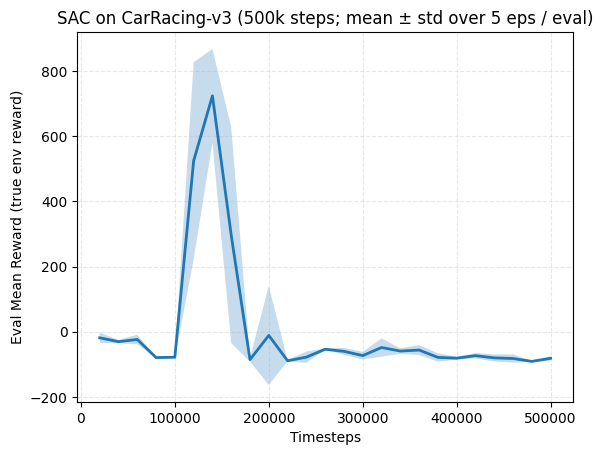

In [13]:
# --------------------
# Plot evaluation curve (from EvalCallback)
# --------------------
eval_npz = os.path.join(LOG_DIR, "evaluations.npz")
if os.path.exists(eval_npz):
    data = np.load(eval_npz)
    timesteps = data["timesteps"]
    results = data["results"]
    mean_results = results.mean(axis=1)
    std_results = results.std(axis=1)

    plt.figure()
    plt.plot(timesteps, mean_results, linewidth=2)
    plt.fill_between(timesteps, mean_results - std_results, mean_results + std_results, alpha=0.25)
    plt.xlabel("Timesteps")
    plt.ylabel("Eval Mean Reward (true env reward)")
    plt.title(f"SAC on {ENV_ID} (500k steps; mean ± std over {EVAL_EPISODES} eps / eval)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()
else:
    print("evaluations.npz not found; was EvalCallback attached?")

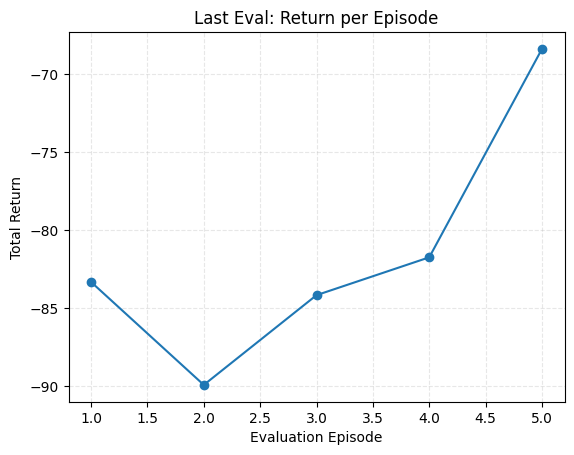

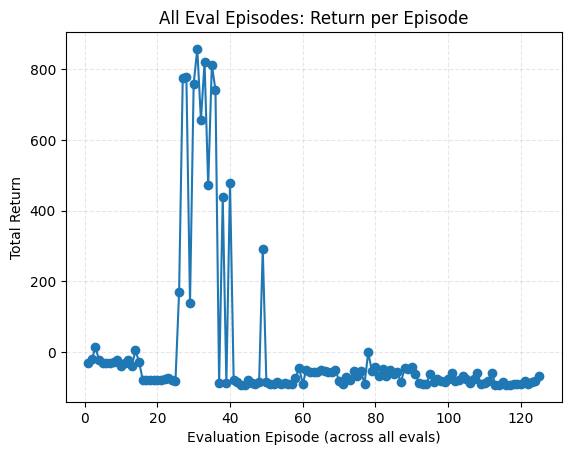

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

LOG_DIR = "./logs/CarRacing-v3"  # change if yours differs
npz_path = os.path.join(LOG_DIR, "evaluations.npz")
data = np.load(npz_path)

# results shape: (num_evals, episodes_per_eval)
results = data["results"]

# Option 1: last evaluation only
last_returns = results[-1]  # shape (episodes_per_eval,)
plt.figure()
plt.plot(range(1, len(last_returns)+1), last_returns, marker="o")
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Return")
plt.title("Last Eval: Return per Episode")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Option 2: all evaluations flattened into a single sequence
flat_returns = results.reshape(-1)
plt.figure()
plt.plot(range(1, len(flat_returns)+1), flat_returns, marker="o")
plt.xlabel("Evaluation Episode (across all evals)")
plt.ylabel("Total Return")
plt.title("All Eval Episodes: Return per Episode")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


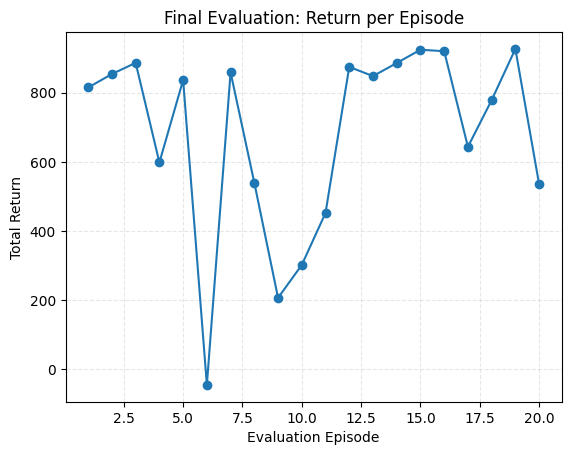

In [15]:
# Rebuild eval env with saved VecNormalize stats, then disable reward norm
eval_env = load_eval_env_with_stats()

# Load whichever model you want to plot
model_to_plot = SAC.load(best_model_path, env=eval_env)  # or final_model_path

# Get per-episode returns
episode_returns, episode_lengths = evaluate_policy(
    model_to_plot, eval_env,
    n_eval_episodes=20,
    deterministic=True,
    return_episode_rewards=True
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, len(episode_returns)+1), episode_returns, marker="o")
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Return")
plt.title("Final Evaluation: Return per Episode")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

eval_env.close()


In [16]:
# Save PNG locally then copy to Drive
plt.savefig("/content/episode_returns.png", dpi=150, bbox_inches="tight")

from google.colab import drive
drive.mount('/content/drive')
import os, shutil
dst_dir = "/content/drive/MyDrive/CarRacingFigures"
os.makedirs(dst_dir, exist_ok=True)
shutil.copy("/content/episode_returns.png", f"{dst_dir}/episode_returns.png")
print("Saved to:", f"{dst_dir}/episode_returns.png")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to: /content/drive/MyDrive/CarRacingFigures/episode_returns.png


<Figure size 640x480 with 0 Axes>